In [94]:
%matplotlib inline
import os, sys, inspect, warnings
curr_dir = os.path.dirname(os.path.abspath(inspect.getfile(inspect.currentframe()))) # script directory
main_dir = '/'.join(curr_dir.split('/')[:-1])
sub_dir = os.path.join(main_dir, 'RGCPD/')
# core_pp = os.path.join(main_dir, 'RGCPD/core')
if main_dir not in sys.path:
    sys.path.append(main_dir)
    sys.path.append(sub_dir)
import numpy as np 
from collections import Counter
# import statsmodels.api as sm 
import pandas as pd 
import math
import matplotlib.pyplot as plt 
plt.rcParams['figure.figsize'] = (20.0, 10.0)
import itertools as it
import pywt as wv
from scipy.fftpack import fft
# from statsmodels.tsa.arima_process import  arma_generate_sample, ArmaProcess
from pprint import pprint as pp 
from pandas.plotting import register_matplotlib_converters
from RGCPD import RGCPD
from RGCPD import BivariateMI
import core_pp
import scipy
# import dit 
register_matplotlib_converters()
np.random.seed(12345)
plt.style.use('seaborn')

In [2]:
path_data = os.path.join(main_dir, 'data')
current_analysis_path = os.path.join(main_dir, 'Jier_analysis')
target= 3
target_path = os.path.join(path_data, 'tf5_nc5_dendo_80d77.nc')
precursor_path = os.path.join(path_data,'sst_1979-2018_2.5deg_Pacific.nc')
list_of_name_path = [(target, target_path), 
                    ('sst', precursor_path )]
list_for_MI = [BivariateMI(name='sst', func=BivariateMI.corr_map, 
                          kwrgs_func={'alpha':.0001, 'FDR_control':True}, 
                          distance_eps=700, min_area_in_degrees2=5)]


In [3]:
rg = RGCPD(list_of_name_path=list_of_name_path,
           list_for_MI=list_for_MI,
           path_outmain=os.path.join(main_dir,'data'))


In [4]:
rg.pp_precursors(detrend=True, anomaly=True, selbox=None)
rg.pp_TV()
rg.traintest(method='no_train_test_split')
rg.calc_corr_maps()
rg.cluster_list_MI()
# rg.get_ts_prec(precur_aggr=1)
rg.get_ts_prec()


Loaded pre-processed data of sst

original tfreq of imported response variable is converted to desired tfreq 10
No train test split

sst - calculating correlation maps
Progress traintest set 100%, trainsize=(320dp, 100%)


Getting MI timeseries
There are [2] regions in total (list of different splits)


In [5]:
rg.PCMCI_df_data()

Progress causal inference - traintest set 100%

In [6]:
data = rg.df_data


In [7]:
data.columns 

Index(['3ts', '0..1..sst', '0..2..sst', 'TrainIsTrue', 'RV_mask'], dtype='object')

In [8]:
data.head(10)

3ts  0..1..sst  0..2..sst  TrainIsTrue  RV_mask
0 1979-01-11 -7.834037   0.170936  -0.008188         True    False
  1979-01-21 -1.560857  -0.079309   0.504746         True    False
  1979-01-31 -6.039140  -0.088057   0.326127         True    False
  1979-02-10 -8.095633  -0.333671   0.418299         True    False
  1979-02-20 -4.562972  -0.338733   1.275768         True    False
  1979-03-02 -0.246385  -0.277471   1.197117         True    False
  1979-03-12 -1.409679  -0.170107   0.417160         True    False
  1979-03-22  1.232596  -0.235621   0.686597         True    False
  1979-04-01 -0.434562  -0.070553   0.364636         True    False
  1979-04-11 -1.850989  -0.202277   0.411490         True    False

In [9]:
rg_data  = data[['3ts', '0..1..sst', '0..2..sst']]
rg_data.tail(10)

3ts  0..1..sst  0..2..sst
0 2018-09-28 -1.965809  -0.045731  -0.639141
  2018-10-08  0.243123   0.116764  -0.739988
  2018-10-18 -4.524243   0.320273  -0.607359
  2018-10-28 -1.550640   0.380495  -0.422838
  2018-11-07 -4.297380   0.506998  -0.343699
  2018-11-17 -6.276446   0.657714  -0.744246
  2018-11-27 -1.824193   0.722903  -0.656277
  2018-12-07 -3.683314   0.646479  -0.626174
  2018-12-17  3.248923   0.489803  -0.432206
  2018-12-27  1.954863   0.369166  -0.340392

In [10]:
rg_data = rg_data.rename(columns={'3ts':'target', '0..1..sst':'prec1', '0..2..sst':'prec2'})

In [11]:
def shanon_entropy(signal):
    if len(signal) <= 1:
        return 0
    counts = Counter()
    for s in signal: 
        counts[s] += 1
    probs = [float(count) / len(signal) for count in counts.values()]
    w_entropy =[ -p * math.log(p, 2) for p in probs if p > 0 ] 
    return sum(w_entropy)

In [12]:
def energy_at_level(coeffs, level): 
    if len(coeffs) < level:
        print('Smaall', len(coeffs))
        return 0
    else:
        return np.sqrt(np.sum(np.array(coeffs[-level]) ** 2) / len(coeffs) )

In [13]:
ap = rg_data['prec1'].values
families = ['haar','db1','db2', 'db3','db4', 'db5', 'db6', 'db7']
# levels = [wv.dwt_max_level(len(rg_data['prec1'].values), i)+1 for i in families]
for fam in families:
    for i in range(wv.dwt_max_level(len(rg_data['prec1'].values), fam)):
        ap, det =  wv.dwt(ap, fam)
        e_ap = energy_at_level(ap, i)
        e_det = energy_at_level(det, i)
        print('index', i,'fam wave ', fam, 'ap', e_ap) #,'', 'det', e_det*len(det)) #* Need to multiply by len()? for percentage?q
    print('------------------------------------')

index 0 fam wave  haar ap 0.0024145760416110175
index 1 fam wave  haar ap 0.058722200503441804
index 2 fam wave  haar ap 0.007120505849925265
index 3 fam wave  haar ap 0.1258499346572039
index 4 fam wave  haar ap 0.7356091747146677
index 5 fam wave  haar ap 1.1424448756363095
index 6 fam wave  haar ap 0.6027187356026746
Smaall 6
Smaall 6
index 7 fam wave  haar ap 0
Smaall 3
Smaall 3
index 8 fam wave  haar ap 0
Smaall 2
Smaall 2
index 9 fam wave  haar ap 0
------------------------------------
index 0 fam wave  db1 ap 0.45012769229477106
index 1 fam wave  db1 ap 0.6365766872429686
Smaall 1
Smaall 1
index 2 fam wave  db1 ap 0
Smaall 1
Smaall 1
index 3 fam wave  db1 ap 0
Smaall 1
Smaall 1
index 4 fam wave  db1 ap 0
Smaall 1
Smaall 1
index 5 fam wave  db1 ap 0
Smaall 1
Smaall 1
index 6 fam wave  db1 ap 0
Smaall 1
Smaall 1
index 7 fam wave  db1 ap 0
Smaall 1
Smaall 1
index 8 fam wave  db1 ap 0
Smaall 1
Smaall 1
index 9 fam wave  db1 ap 0
------------------------------------
index 0 fam wave 

In [14]:
def energy(coeffs): 
    return np.sqrt(np.sum(np.array(coeffs) ** 2) / len(coeffs) )
def entropy(signal):
    counts = Counter(signal).most_common()
    probs = [float(count[1]) / len(signal) for count in counts]
    w_entropy =scipy.stats.entropy(probs)
    return w_entropy


In [91]:
def renyi_entropy(X, alpha):
    assert alpha >= 0, "Error: renyi_entropy only accepts values of alpha >= 0, but alpha = {}.".format(alpha)  # DEBUG
    if np.isinf(alpha):
        # XXX Min entropy!
        return - np.log2(np.max(X))
    elif np.isclose(alpha, 0):
        # XXX Max entropy!
        return np.log2(len(X))
    elif np.isclose(alpha, 1):
        # XXX Shannon entropy!
        return entropy(X)
    else:
        counts = Counter(X).most_common()
        probs = np.array([float(count[1]) / len(X) for count in counts])
        return (1.0 / (1.0 - alpha)) * np.log2(np.sum(probs ** alpha))

In [105]:
ap = rg_data['prec1'].values
families = ['haar','db1','db2', 'db3','db4', 'db5', 'db6', 'db7']
# levels = [wv.dwt_max_level(len(rg_data['prec1'].values), i)+1 for i in families]
print("OG signal ", entropy(ap))

for fam in families:
    rennies = []
    for i in range(wv.dwt_max_level(len(rg_data['prec1'].values), fam)):
        ap, det =  wv.dwt(ap, fam)
        e_ap = energy(ap)
        ren = renyi_entropy(ap, 3)
        rennies.append(ren)
        entr = entropy(ap)
        ratio = e_ap/ entr if entr else 0.0
        r_ren = e_ap/ ren if ren else 0.0
        bit = rennies[0] - rennies[i-1] if len(rennies) > 2 else 0.0
        print('index', i,'wave ', fam, 'energy', e_ap, 'entropy sh', entr, 'renyi', ren,  'ratio shanny', ratio, "ratio renny", r_ren,'Renyi bit of info', round(bit) ) #,'', 'det', e_det*len(det)) #* Need to multiply by len()? for percentage?q
    print('------------------------------------')

OG signal  7.272398392570048
index 0 wave  haar energy 0.6317231303491061 entropy sh 6.579251212010099 renyi 9.491853096329674 ratio shanny 0.09601748132005153 ratio renny 0.06655424646146092 Renyi bit of info 0
index 1 wave  haar energy 0.875533143031461 entropy sh 5.886104031450156 renyi 8.491853096329674 ratio shanny 0.14874578131024918 ratio renny 0.10310271893538545 Renyi bit of info 0
index 2 wave  haar energy 1.202127819956825 entropy sh 5.192956850890212 renyi 7.491853096329675 ratio shanny 0.23149197162128318 ratio renny 0.16045800745155536 Renyi bit of info 1.0
index 3 wave  haar energy 1.6273587078907457 entropy sh 4.499809670330265 renyi 6.491853096329675 ratio shanny 0.3616505646051703 ratio renny 0.25067706920398614 Renyi bit of info 2.0
index 4 wave  haar energy 2.1381624222725293 entropy sh 3.8066624897703196 renyi 5.491853096329675 ratio shanny 0.5616895188418815 ratio renny 0.3893335063353224 Renyi bit of info 3.0
index 5 wave  haar energy 2.734701109317436 entropy sh

In [106]:
ap_ = rg_data['prec2'].values
families = ['haar','db1','db2', 'db3','db4', 'db5', 'db6', 'db7']
# levels = [wv.dwt_max_level(len(rg_data['prec1'].values), i)+1 for i in families]
print("OG signal ", entropy(ap_))

for fam in families:
    rennies = []
    for i in range(wv.dwt_max_level(len(rg_data['prec2'].values), fam)):
        ap_, det =  wv.dwt(ap_, fam)
        e_ap = energy(ap_)
        ren = renyi_entropy(ap_, 3)
        rennies.append(ren)
        entr = entropy(ap_)
        ratio = e_ap/ entr if entr else 0.0
        r_ren = e_ap/ ren if ren else 0.0
        bit = rennies[0] - rennies[i-1] if len(rennies) > 2 else 0.0
        print('index', i,'wave ', fam, 'energy', e_ap, 'entropy sh', entr, 'renyi', ren,  'ratio shanny', ratio, "ratio renny", r_ren,'Renyi bit of info', round(bit) ) #,'', 'det', e_det*len(det)) #* Need to multiply by len()? for percentage?q
    print('------------------------------------')

OG signal  7.272398392570048
index 0 wave  haar energy 1.036811797363785 entropy sh 6.579251212010099 renyi 9.491853096329674 ratio shanny 0.15758811511424523 ratio renny 0.10923175768119515 Renyi bit of info 0
index 1 wave  haar energy 1.3965370100244865 entropy sh 5.886104031450156 renyi 8.491853096329674 ratio shanny 0.23725999448236434 ratio renny 0.16445609623511906 Renyi bit of info 0
index 2 wave  haar energy 1.8251863600161895 entropy sh 5.192956850890212 renyi 7.491853096329675 ratio shanny 0.35147343073018283 ratio renny 0.24362281755235757 Renyi bit of info 1.0
index 3 wave  haar energy 2.2227999287264457 entropy sh 4.499809670330265 renyi 6.491853096329675 ratio shanny 0.4939764326883858 ratio renny 0.3423983715810142 Renyi bit of info 2.0
index 4 wave  haar energy 2.843814616117031 entropy sh 3.8066624897703196 renyi 5.491853096329675 ratio shanny 0.7470624526758652 ratio renny 0.5178242327744735 Renyi bit of info 3.0
index 5 wave  haar energy 3.559493412399822 entropy sh 

In [107]:
apt = rg_data['target'].values
families = ['haar','db1','db2', 'db3','db4', 'db5', 'db6', 'db7']
# levels = [wv.dwt_max_level(len(rg_data['prec1'].values), i)+1 for i in families]
print("OG signal ", entropy(apt))

for fam in families:
    rennies = []
    for i in range(wv.dwt_max_level(len(rg_data['target'].values), fam)):
        apt, det =  wv.dwt(apt, fam)
        e_ap = energy(apt)
        ren = renyi_entropy(apt, 3)
        rennies.append(ren)
        entr = entropy(apt)
        ratio = e_ap/ entr if entr else 0.0
        r_ren = e_ap/ ren if ren else 0.0
        bit = rennies[0] - rennies[i-1] if len(rennies) > 2 else 0.0
        print('index', i,'wave ', fam, 'energy', e_ap, 'entropy sh', entr, 'renyi', ren,  'ratio shanny', ratio, "ratio renny", r_ren,'Renyi bit of info', round(bit) ) #,'', 'det', e_det*len(det)) #* Need to multiply by len()? for percentage?q
    print('------------------------------------')

OG signal  7.272398392570048
index 0 wave  haar energy 3.415827382471334 entropy sh 6.579251212010099 renyi 9.491853096329674 ratio shanny 0.5191817841270309 ratio renny 0.3598693898657336 Renyi bit of info 0
index 1 wave  haar energy 3.8967607761335326 entropy sh 5.886104031450156 renyi 8.491853096329674 ratio shanny 0.6620271669193536 ratio renny 0.45888226420423833 Renyi bit of info 0
index 2 wave  haar energy 4.0634035697261055 entropy sh 5.192956850890212 renyi 7.491853096329675 ratio shanny 0.7824835996912874 ratio renny 0.542376300960413 Renyi bit of info 1.0
index 3 wave  haar energy 4.750529602335624 entropy sh 4.499809670330265 renyi 6.491853096329675 ratio shanny 1.0557178970609566 ratio renny 0.7317678838144767 Renyi bit of info 2.0
index 4 wave  haar energy 5.629739558866209 entropy sh 3.8066624897703196 renyi 5.491853096329675 ratio shanny 1.4789174438225248 ratio renny 1.0251074564665044 Renyi bit of info 3.0
index 5 wave  haar energy 5.1166090648997145 entropy sh 3.1354

In [18]:
def choose_family(signal, families, levels_, debug= False):
    entropy_score = []
    origin_entropy = shanon_entropy(signal)
    print('Origin entropy', origin_entropy)

    for wave in families:
        if debug == False:
            levels = max_level_data(data, wave)
        else:
            levels = levels_
        for level in range(1, levels+1):
            coefs = wv.wavedec(signal, wave, mode='smooth', level=level)
            if len(coefs) > 1 :
                for i, coeff in enumerate(coefs):
                    if debug == True:
                        print('shanny', shanon_entropy(coeff), 'coeff', i,  'level', level, wave, '\n')
                    entropy_score.append((shanon_entropy(coeff),i, wave, level))
            else:
                if debug == True:
                    print('shanny', shanon_entropy(coeff), 'coeff', i,  'level', level, wave, '\n')
                entropy_score.append((shanon_entropy(coefs), wave, level))
    return entropy_score

In [19]:
def max_level_data(data, wave):
    return wv.dwt_max_level(len(data), wv.Wavelet(wave).dec_len)+1

In [20]:
families = ['haar','db1','db2', 'db3','db4', 'db5', 'db6']

a = rg_data['prec1'].values
levels = [wv.dwt_max_level(len(a), i)+1 for i in families]

choose_family(a, families=families, levels_=levels)

Origin entropy 10.49185309632981


[(9.491853096329773, 0, 'haar', 1),
 (9.491853096329773, 1, 'haar', 1),
 (8.491853096329654, 0, 'haar', 2),
 (8.491853096329654, 1, 'haar', 2),
 (9.491853096329773, 2, 'haar', 2),
 (7.491853096329661, 0, 'haar', 3),
 (7.491853096329661, 1, 'haar', 3),
 (8.491853096329654, 2, 'haar', 3),
 (9.491853096329773, 3, 'haar', 3),
 (6.491853096329662, 0, 'haar', 4),
 (6.491853096329662, 1, 'haar', 4),
 (7.491853096329661, 2, 'haar', 4),
 (8.491853096329654, 3, 'haar', 4),
 (9.491853096329773, 4, 'haar', 4),
 (5.491853096329673, 0, 'haar', 5),
 (5.491853096329673, 1, 'haar', 5),
 (6.491853096329662, 2, 'haar', 5),
 (7.491853096329661, 3, 'haar', 5),
 (8.491853096329654, 4, 'haar', 5),
 (9.491853096329773, 5, 'haar', 5),
 (4.523561956057013, 0, 'haar', 6),
 (4.523561956057013, 1, 'haar', 6),
 (5.491853096329673, 2, 'haar', 6),
 (6.491853096329662, 3, 'haar', 6),
 (7.491853096329661, 4, 'haar', 6),
 (8.491853096329654, 5, 'haar', 6),
 (9.491853096329773, 6, 'haar', 6),
 (3.584962500721156, 0, 'haa

In [21]:
def apply_concat_series(series, func, arg=None):
    return zip(*series.apply(func, args=(arg,)))

In [22]:
def plot_signal_decomp(data, w, mode, title, level):
    """Decompose and plot a signal S.
    S = An + Dn + Dn-1 + ... + D1
    """
    w = wv.Wavelet(w)
    a = data
    ca = []
    cd = []
    level_ = wv.dwt_max_level(len(data), w.dec_len)
    if level > level_:
        level = level_
        print("Appropriate level is changed to ", level)
    else:
        level_ = None 
    for i in range(level):
        (a, d) = wv.dwt(a, w, mode)
        ca.append(a)
        cd.append(d)

    rec_a = []
    rec_d = []

    for i, coeff in enumerate(ca):
        coeff_list = [coeff, None] + [None] * i
        rec_a.append(wv.waverec(coeff_list, w))

    for i, coeff in enumerate(cd):
        coeff_list = [None, coeff] + [None] * i
        rec_d.append(wv.waverec(coeff_list, w))

    fig = plt.figure(figsize=(16,9))
    ax_main = fig.add_subplot(len(rec_a) + 1, 1, 1)
    ax_main.set_title(title)
    ax_main.plot(data)
    ax_main.set_xlim(0, len(data) - 1)

    for i, y in enumerate(rec_a):
        ax = fig.add_subplot(len(rec_a) + 1, 2, 3 + i * 2)
        ax.plot(y, 'r')
        ax.set_xlim(0, len(y) - 1)
        ax.set_ylabel("A%d" % (i + 1))

    for i, y in enumerate(rec_d):
        ax = fig.add_subplot(len(rec_d) + 1, 2, 4 + i * 2)
        ax.plot(y, 'g')
        ax.set_xlim(0, len(y) - 1)
        ax.set_ylim(min(0, 1.4 * min(y)), max(0, 1.4 * max(y)))
        ax.set_ylabel("D%d" % (i + 1))
    plt.tight_layout()
    

In [23]:

# plot_signal_decomp(rg_data['prec1'].values, 'db3','smooth','Precursor1',9)


In [24]:
def plot_coeffs(data, w, mode, title, level, use_dwt=True):
    """Show dwt or swt coefficients for given data and wavelet."""
    w = wv.Wavelet(w)
    a = data
    ca = []
    cd = []
    if use_dwt:
        level_ = wv.dwt_max_level(len(data), w.dec_len)
    else:
        level_ = wv.swt_max_level(len(data))
    if level > level_:
        level = level_
        print("Appropriate level is changed to ", level)
    else:
        level_ = None 
    if use_dwt:
        for i in range(level):
            (a, d) = wv.dwt(a, w, mode) #  [(cAn, (cDn, ...,cDn-1, cD1)]
            ca.append(a)
            cd.append(d)
    else:
        coeffs = wv.swt(data, w, level)  # [(cA5, cD5), ..., (cA1, cD1)]
        for a, d in reversed(coeffs):
            ca.append(a)
            cd.append(d)

    fig = plt.figure(figsize=(16,9))
    ax_main = fig.add_subplot(len(ca) + 1, 1, 1)
    ax_main.set_title(title)
    ax_main.plot(data)
    ax_main.set_xlim(0, len(data) - 1)

    for i, x in enumerate(ca):
        ax = fig.add_subplot(len(ca) + 1, 2, 3 + i * 2)
        ax.plot(x, 'r')
        ax.set_ylabel("A%d" % (i + 1))
        if use_dwt:
            ax.set_xlim(0, len(x) - 1)
        else:
            ax.set_xlim(w.dec_len * i, len(x) - 1 - w.dec_len * i)

    for i, x in enumerate(cd):
        ax = fig.add_subplot(len(cd) + 1, 2, 4 + i * 2)
        ax.plot(x, 'g')
        ax.set_ylabel("D%d" % (i + 1))
        # Scale axes
        ax.set_xlim(0, len(x) - 1)
        if use_dwt:
            ax.set_ylim(min(0, 1.4 * min(x)), max(0, 1.4 * max(x)))
        else:
            vals = x[w.dec_len * (1 + i):len(x) - w.dec_len * (1 + i)]
            ax.set_ylim(min(0, 2 * min(vals)), max(0, 2 * max(vals)))
        plt.tight_layout()


In [25]:
# plot_coeffs(rg_data['prec1'].values, 'db3','smooth','Precursor1CoeffWithDWT',9)

In [26]:
# plot_coeffs(rg_data['prec1'].values, 'db3','smooth','Precursor1CoeffWithSWT',9, use_dwt=False)

In [27]:
def lowpassfilter(signal, thresh = 0.63, wavelet="haar"):
    thresh = thresh*np.nanmax(signal)
    coeff = wv.wavedec(signal, wavelet, mode="per" )
    coeff[1:] = (wv.threshold(i, value=thresh, mode="soft" ) for i in coeff[1:])
    reconstructed_signal = wv.waverec(coeff, wavelet, mode="per" )
    return reconstructed_signal


In [28]:
def denoise_high_frequency(signal, thresh, wavelet):
    new_signal = lowpassfilter(signal, thresh, wavelet)
    fig, ax = plt.subplots(figsize=(16, 9))
    ax.plot(signal, 'r', alpha=0.5, label='original')
    ax.legend()
    ax.plot(new_signal, 'k', alpha=0.4, label='denoised')
    ax.legend()

In [29]:
# denoise_high_frequency(rg_data['prec1'].values, thresh=0.6, wavelet='db3')

In [30]:
new_signal = lowpassfilter(rg_data['prec1'].values, thresh=0.1, wavelet='db3')
# plot_signal_decomp(new_signal, 'db3','smooth','Precursor1',9)

In [31]:
# plot_coeffs(new_signal,'db3','smooth','Precursor1',9 )

In [32]:
# plot_coeffs(new_signal,'db3','smooth','Precursor1',9, use_dwt=False )

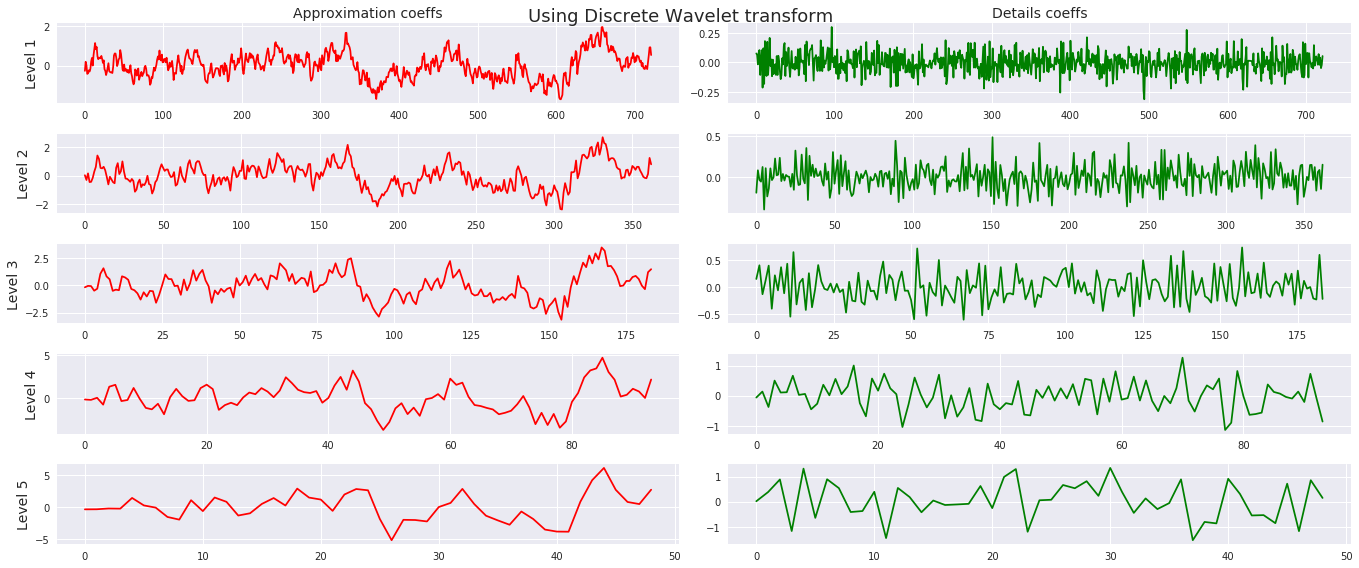

In [33]:
fig, ax = plt.subplots(5, 2, figsize=(19, 8))
fig.suptitle('Using Discrete Wavelet transform', fontsize=18)
ap = rg_data['prec1'].values
for i in range(5):
   ap, det =  wv.dwt(ap, 'db3')
   ax[i, 0].plot(ap, 'r')
   ax[i, 1].plot(det, 'g')
   ax[i, 0].set_ylabel('Level {}'.format(i + 1), fontsize=14, rotation=90)
   if i == 0:
        ax[i, 0].set_title('Approximation coeffs', fontsize=14)
        ax[i, 1].set_title('Details coeffs', fontsize=14)
plt.tight_layout()
plt.show()

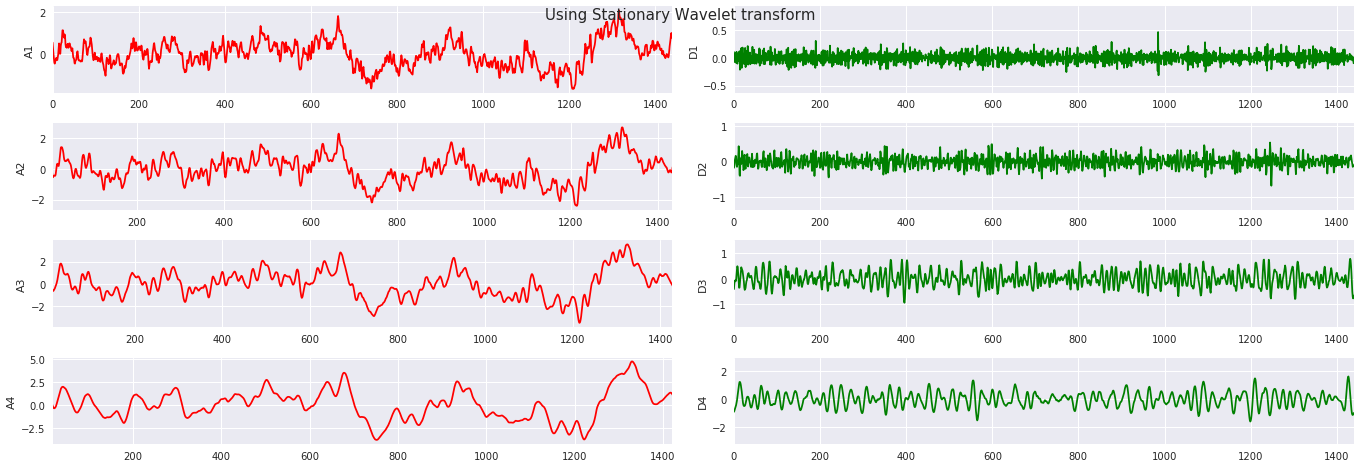

In [34]:
fig = plt.figure(figsize=(19, 8))
fig.suptitle('Using Stationary Wavelet transform', fontsize=15)
a = rg_data['prec1'].values
w  = wv.Wavelet('db3')
coeffs =  wv.swt(a, w, 4)
ca , cd = [], []
for ap, det  in reversed(coeffs):
    ca.append(ap)
    cd.append(det)
for i, x in enumerate(ca):
    ax = fig.add_subplot(len(ca) + 1, 2, 1 + i * 2)
    ax.plot(x, 'r')
    ax.set_ylabel("A%d" % (i + 1))
    ax.set_xlim(w.dec_len * i, len(x) - 1 - w.dec_len * i)

for i, x in enumerate(cd):
    ax = fig.add_subplot(len(cd) + 1, 2, 2 + i * 2)
    ax.plot(x, 'g')
    ax.set_ylabel("D%d" % (i + 1))
    # Scale axes
    ax.set_xlim(0, len(x) - 1)
    vals = x[w.dec_len * (1 + i):len(x) - w.dec_len * (1 + i)]
    ax.set_ylim(min(0, 2 * min(vals)), max(0, 2 * max(vals)))
plt.tight_layout()

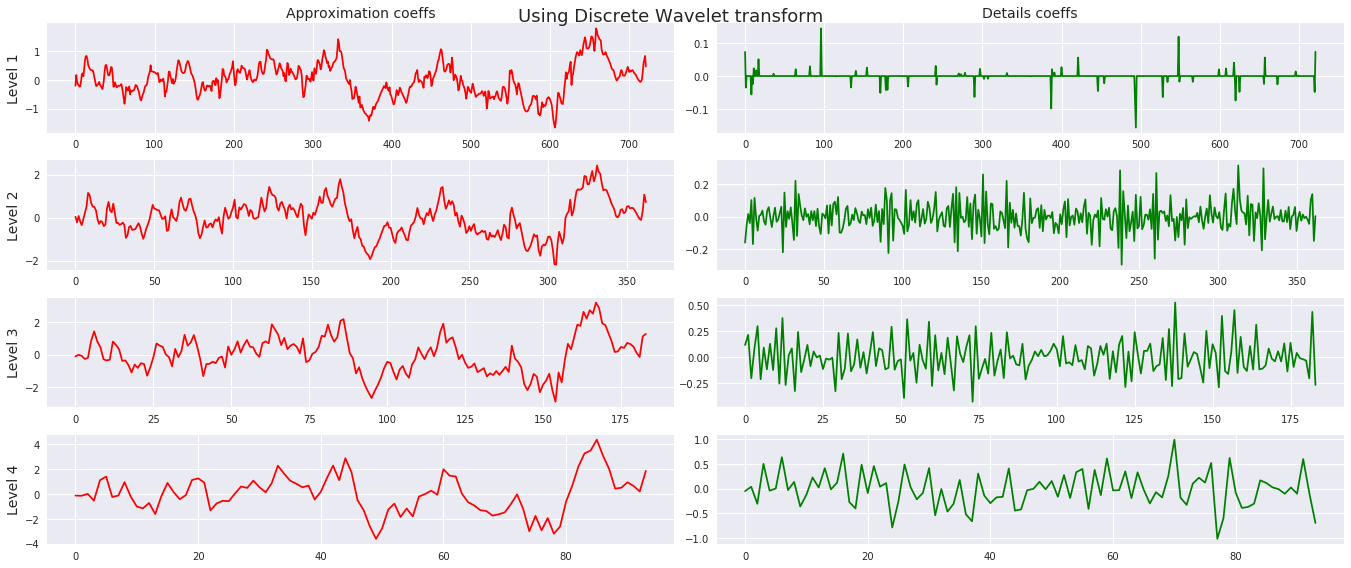

In [35]:
fig, ax = plt.subplots(4, 2, figsize=(19, 8))
fig.suptitle('Using Discrete Wavelet transform', fontsize=18)
ap = new_signal
for i in range(4):
   ap, det =  wv.dwt(ap, 'db3')
   ax[i, 0].plot(ap, 'r')
   ax[i, 1].plot(det, 'g')
   ax[i, 0].set_ylabel('Level {}'.format(i + 1), fontsize=14, rotation=90)
   if i == 0:
        ax[i, 0].set_title('Approximation coeffs', fontsize=14)
        ax[i, 1].set_title('Details coeffs', fontsize=14)
plt.tight_layout()
plt.show()

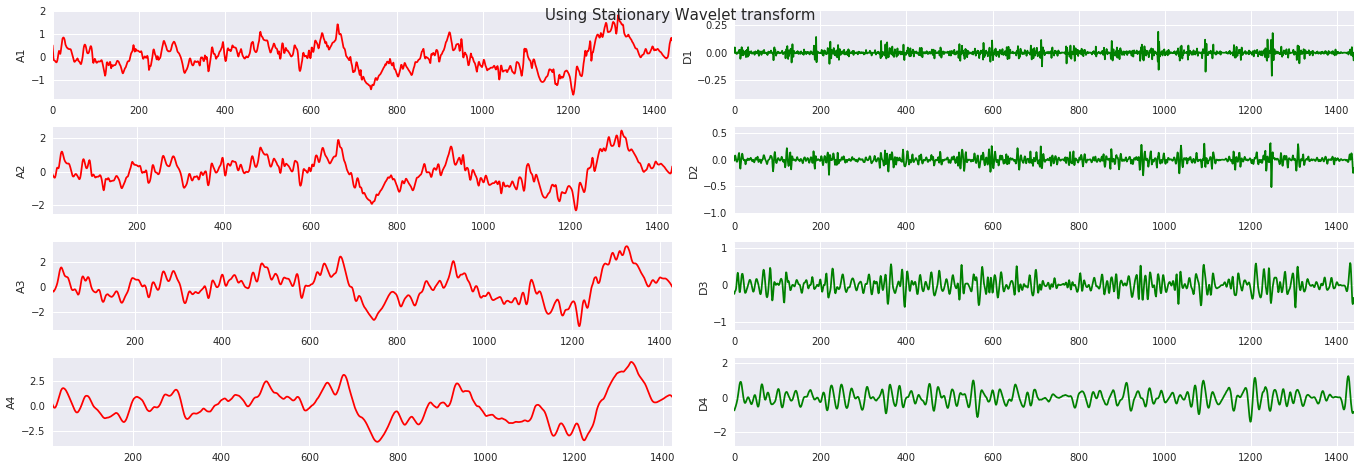

In [36]:
fig = plt.figure(figsize=(19, 8))
fig.suptitle('Using Stationary Wavelet transform', fontsize=15)
a = new_signal
w  = wv.Wavelet('db3')
coeffs =  wv.swt(a, w, 4)
ca , cd = [], []
for ap, det  in reversed(coeffs):
    ca.append(ap)
    cd.append(det)
for i, x in enumerate(ca):
    ax = fig.add_subplot(len(ca) + 1, 2, 1 + i * 2)
    ax.plot(x, 'r')
    ax.set_ylabel("A%d" % (i + 1))
    ax.set_xlim(w.dec_len * i, len(x) - 1 - w.dec_len * i)

for i, x in enumerate(cd):
    ax = fig.add_subplot(len(cd) + 1, 2, 2 + i * 2)
    ax.plot(x, 'g')
    ax.set_ylabel("D%d" % (i + 1))
    # Scale axes
    ax.set_xlim(0, len(x) - 1)
    vals = x[w.dec_len * (1 + i):len(x) - w.dec_len * (1 + i)]
    ax.set_ylim(min(0, 2 * min(vals)), max(0, 2 * max(vals)))
plt.tight_layout()

In [38]:
# N= rg_data['prec1'].values.shape[0]
# t0=1975
# dt = 0.10
# time = np.arange(0, N) * dt + t0
# signal = rg_data[ 'prec1'].values.squeeze()
# scales = np.arange(1, 128)
# time
# plot_signal_plus_average(time, signal)
# plot_fft_plus_power(time, signal)
# plot_wavelet(time, signal, scales)

In [39]:
# N= rg_data['prec2'].values.shape[0]
# t0=1975
# dt = 0.10
# time = np.arange(0, N) * dt + t0
# signal = rg_data[ 'prec2'].values.squeeze()
# scales = np.arange(1, 128)
# plot_signal_plus_average(time, signal)
# plot_fft_plus_power(time, signal)
# plot_wavelet(time, signal, scales)

In [42]:
rg_index = rg_data.index.levels[1]
prec1 = rg_data['prec1'].values
prec2 = rg_data['prec2'].values
target = rg_data['target'].values
wave  = wv.Wavelet('db3')
mode=wv.Modes.periodic


In [43]:
level_ = wv.dwt_max_level(len(prec1), wave.dec_len)
print("Possible levels of decompositions: ", level_)
print("Length returned from dwt:", wv.dwt_coeff_len(len(prec1), filter_len=wave, mode=mode), "Len original signal:", len(prec1))
coeff_1 = wv.wavedec(prec1, wave, mode=mode, level=level_)

Possible levels of decompositions:  8
Length returned from dwt: 722 Len original signal: 1440


In [44]:
for i, c in enumerate(coeff_1): # Wavedecomposition only returns the last cA and the rest are cD's details 
    print(i, len(c))

0 10
1 10
2 16
3 27
4 49
5 94
6 184
7 363
8 722


In [45]:
# Using recursion we obtain all of our approximation coefficients with just dwt
signal = prec1
cA, cD = [], []
for i in range(level_): # Using recursion to overwrite signal to go level deepeer
   signal, det =  wv.dwt(signal, wave , mode=mode)
   print('Len Sign ', len(signal), 'Lenght detail ', len(det))
   cA.append(signal)
   cD.append(det)
print('Inspecting approximations length')
for i, c in enumerate(cA):
    print(i, len(c))
print('Inspecting details length')
for i, d in enumerate(cD):
    print(i, len(d))

Len Sign  722 Lenght detail  722
Len Sign  363 Lenght detail  363
Len Sign  184 Lenght detail  184
Len Sign  94 Lenght detail  94
Len Sign  49 Lenght detail  49
Len Sign  27 Lenght detail  27
Len Sign  16 Lenght detail  16
Len Sign  10 Lenght detail  10
Inspecting approximations length
0 722
1 363
2 184
3 94
4 49
5 27
6 16
7 10
Inspecting details length
0 722
1 363
2 184
3 94
4 49
5 27
6 16
7 10


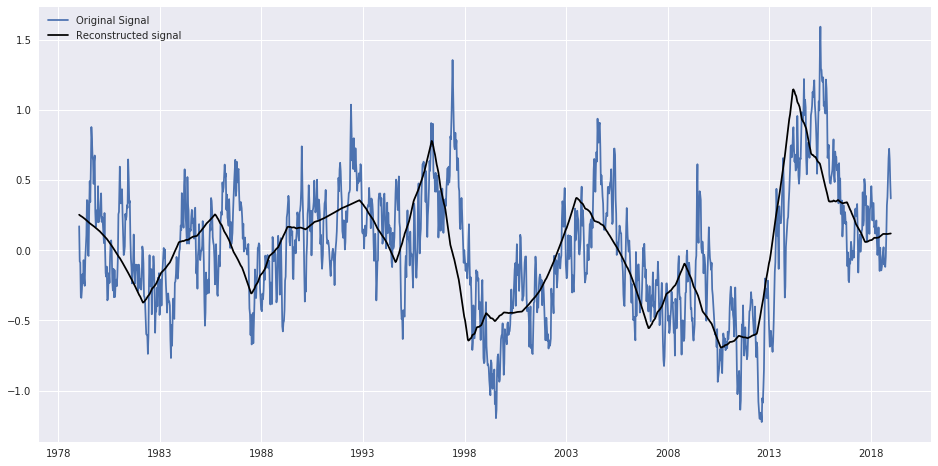

In [46]:
test = wv.upcoef('a', cA[5], wave, level=6, take=len(prec1))
plt.figure(figsize=(16, 8))
plt.plot(rg_index.values, prec1, label='Original Signal')
plt.plot(rg_index.values, test,'k', label='Reconstructed signal')
plt.legend()

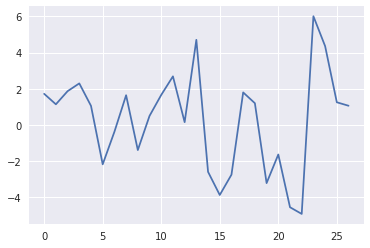

In [47]:
plt.plot(cA[5])

In [48]:
# Using recursion we obtain all of our approximation coefficients with just dwt
signal = prec2
level_ = wv.dwt_max_level(len(signal), wave.dec_len)
cA2, cD2 = [], []
for i in range(level_): # Using recursion to overwrite signal to go level deepeer
   signal, det =  wv.dwt(signal, wave , mode=mode)
   print('Len Sign ', len(signal), 'Lenght detail ', len(det))
   cA2.append(signal)
   cD2.append(det)
print('Inspecting approximations length')
for i, c in enumerate(cA2):
    print(i, len(c))
print('Inspecting details length')
for i, d in enumerate(cD2):
    print(i, len(d))

Len Sign  722 Lenght detail  722
Len Sign  363 Lenght detail  363
Len Sign  184 Lenght detail  184
Len Sign  94 Lenght detail  94
Len Sign  49 Lenght detail  49
Len Sign  27 Lenght detail  27
Len Sign  16 Lenght detail  16
Len Sign  10 Lenght detail  10
Inspecting approximations length
0 722
1 363
2 184
3 94
4 49
5 27
6 16
7 10
Inspecting details length
0 722
1 363
2 184
3 94
4 49
5 27
6 16
7 10


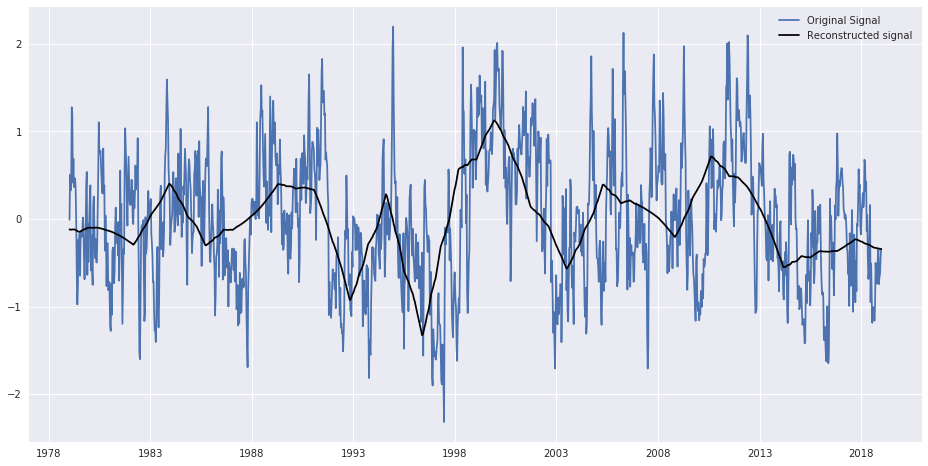

In [49]:
test = wv.upcoef('a', cA2[5], wave, level=6, take=len(prec2))
plt.figure(figsize=(16, 8))
plt.plot(rg_index.values, prec2, label='Original Signal')
plt.plot(rg_index.values, test,'k', label='Reconstructed signal')
plt.legend()

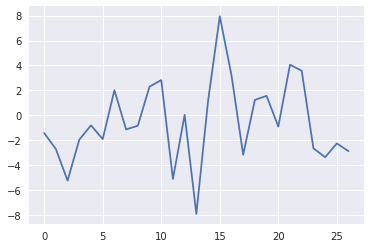

In [50]:
plt.plot(cA2[5])

In [51]:
# ecg = prec1

# wp = wv.WaveletPacket(ecg, wave,mode=mode, maxlevel=level_)

# fig = plt.figure(figsize=(19, 8))
# plt.set_cmap('winter')
# ax = fig.add_subplot(wp.maxlevel + 1, 1, 1)
# ax.plot(ecg, 'k')
# ax.set_xlim(0, len(ecg) - 1)
# ax.set_title("Wavelet packet coefficients")

# for level in range(1, wp.maxlevel + 1):
#     ax = fig.add_subplot(wp.maxlevel + 1, 1, level + 1)
#     nodes = wp.get_level(level, "freq")
#     nodes.reverse()
#     labels = [n.path for n in nodes]
#     values = -abs(np.array([n.data for n in nodes]))
#     ax.imshow(values, interpolation='nearest', aspect='auto')
#     ax.set_yticks(np.arange(len(labels) - 0.5, -0.5, -1), labels)
#     plt.setp(ax.get_xticklabels(), visible=True)

# plt.show()

In [52]:
#  Possible values are: Accent, Accent_r, Blues, Blues_r, BrBG, BrBG_r, BuGn, BuGn_r, BuPu, BuPu_r, CMRmap, CMRmap_r, Dark2, Dark2_r, GnBu, GnBu_r, Greens, Greens_r, Greys, Greys_r, OrRd, OrRd_r, Oranges, Oranges_r, PRGn, PRGn_r, Paired, Paired_r, Pastel1, Pastel1_r, Pastel2, Pastel2_r, PiYG, PiYG_r, PuBu, PuBuGn, PuBuGn_r, PuBu_r, PuOr, PuOr_r, PuRd, PuRd_r, Purples, Purples_r, RdBu, RdBu_r, RdGy, RdGy_r, RdPu, RdPu_r, RdYlBu, RdYlBu_r, RdYlGn, RdYlGn_r, Reds, Reds_r, Set1, Set1_r, Set2, Set2_r, Set3, Set3_r, Spectral, Spectral_r, Wistia, Wistia_r, YlGn, YlGnBu, YlGnBu_r, YlGn_r, YlOrBr, YlOrBr_r, YlOrRd, YlOrRd_r, afmhot, afmhot_r, autumn, autumn_r, binary, binary_r, bone, bone_r, brg, brg_r, bwr, bwr_r, cividis, cividis_r, cool, cool_r, coolwarm, coolwarm_r, copper, copper_r, cubehelix, cubehelix_r, flag, flag_r, gist_earth, gist_earth_r, gist_gray, gist_gray_r, gist_heat, gist_heat_r, gist_ncar, gist_ncar_r, gist_rainbow, gist_rainbow_r, gist_stern, gist_stern_r, gist_yarg, gist_yarg_r, gnuplot, gnuplot2, gnuplot2_r, gnuplot_r, gray, gray_r, hot, hot_r, hsv, hsv_r, icefire, icefire_r, inferno, inferno_r, jet, jet_r, magma, magma_r, mako, mako_r, nipy_spectral, nipy_spectral_r, ocean, ocean_r, pink, pink_r, plasma, plasma_r, prism, prism_r, rainbow, rainbow_r, rocket, rocket_r, seismic, seismic_r, spring, spring_r, summer, summer_r, tab10, tab10_r, tab20, tab20_r, tab20b, tab20b_r, tab20c, tab20c_r, terrain, terrain_r, viridis, viridis_r, vlag, vlag_r, winter, winter_r

In [53]:
# wavelet = 'db3'
# level = 4
# order = "freq"  # other option is "normal"
# interpolation = 'nearest'
# cmap = plt.cm.cool
# x = np.linspace(0, 1, num=1440)
# # x = rg_index.values
# # data = np.sin(250 * np.pi * x**2)
# data = prec1
# # Construct wavelet packet
# wp = wv.WaveletPacket(data, wavelet, mode, maxlevel=level_)
# nodes = wp.get_level(level, order=order)
# labels = [n.path for n in nodes]
# values = np.array([n.data for n in nodes], 'd')
# values = abs(values)

# # Show signal and wavelet packet coefficients
# fig = plt.figure(figsize=(19, 8))
# fig.subplots_adjust(hspace=0.2, bottom=.03, left=.07, right=.97, top=.92)
# ax = fig.add_subplot(2, 1, 1)
# ax.set_title("linchirp signal")
# ax.plot(x, data, 'b')
# ax.set_xlim(0, x[-1])

# ax = fig.add_subplot(2, 1, 2)
# ax.set_title("Wavelet packet coefficients at level %d" % level_)
# ax.imshow(values, interpolation=interpolation, cmap=cmap, aspect="auto",
#           origin="lower", extent=[0, 1, 0, len(values)])
# ax.set_yticks(np.arange(0.5, len(labels) + 0.5), labels)

# # Show spectrogram and wavelet packet coefficients
# fig2 = plt.figure(figsize=(19, 8))
# ax2 = fig2.add_subplot(211)
# ax2.specgram(data, NFFT=64, noverlap=32, Fs=2, cmap=cmap,
#              interpolation='bilinear')
# ax2.set_title("Spectrogram of signal")
# ax3 = fig2.add_subplot(212)
# ax3.imshow(values, origin='upper', extent=[-1, 1, -1, 1],
#            interpolation='nearest')
# ax3.set_title("Wavelet packet coefficients")


# plt.show()

In [54]:
# decomp = np.arange(1, 8)
# order = np.arange(1, 8)[::-1]
# up_coef = []
# to_iter = list(zip(decomp, order))

In [55]:
# print(list(zip(decomp, order)))

In [56]:
# for _, (i, j) in enumerate(to_iter):
#     if j == 1:
#         up_coef.append(wv.upcoef('a', cA[-i], wave, level=j+1, take=len(prec1)))
#     else:
#         up_coef.append(wv.upcoef('a', cA[-i], wave, level=j, take=len(prec1)))

In [57]:
# test_s = pd.Series(data=test, index=rg_data.index)

In [58]:
signalT = target
level_ = wv.dwt_max_level(len(signalT), wave.dec_len)
print(level_)
cAT, cDT = [], []
for i in range(level_): # Using recursion to overwrite signal to go level deepeer
   signalT, det =  wv.dwt(signalT, wave , mode=mode)
   print('Len Sign ', len(signal), 'Lenght detail ', len(det))
   cAT.append(signalT)
   cDT.append(det)
print('Inspecting approximations length')
for i, c in enumerate(cAT):
    print(i, len(c))
print('Inspecting details length')
for i, d in enumerate(cDT):
    print(i, len(d))

8
Len Sign  10 Lenght detail  722
Len Sign  10 Lenght detail  363
Len Sign  10 Lenght detail  184
Len Sign  10 Lenght detail  94
Len Sign  10 Lenght detail  49
Len Sign  10 Lenght detail  27
Len Sign  10 Lenght detail  16
Len Sign  10 Lenght detail  10
Inspecting approximations length
0 722
1 363
2 184
3 94
4 49
5 27
6 16
7 10
Inspecting details length
0 722
1 363
2 184
3 94
4 49
5 27
6 16
7 10


In [59]:
# a = [1, 2,3, 4, 5, 6]
# (ca, cd) = wv.dwt(a, 'db2', 'smooth')
# print(ca)
# wv.upcoef('a', ca, 'db2') 

In [60]:
idx_cA1 = pd.DatetimeIndex(pd.date_range(rg_index[0] ,end=rg_index[-1], periods=len(cA[1])).strftime('%Y-%m-%d') )
idx_tcA1 =pd.DatetimeIndex( pd.date_range(rg_index[0], end=rg_index[-1], periods=len(cAT[1])).strftime('%Y-%m-%d') )


In [61]:

dates = core_pp.get_subdates(dates=idx_cA1, start_end_date=('06-15', '08-20'), start_end_year=None, lpyr=False)
dates_T = core_pp.get_subdates(dates=idx_tcA1, start_end_date=('06-15', '08-20'), start_end_year=None, lpyr=False)

In [62]:
full_time  = idx_cA1
RV_time  = dates
RV_mask = pd.Series(np.array([True if d in RV_time else False for d in full_time]), index=pd.MultiIndex.from_product(([0], idx_cA1)), name='RV_mask')
trainIsTrue = pd.Series(np.array([True for _ in range(len(cAT[1]))]), index=pd.MultiIndex.from_product(([0], idx_cA1)), name='TrainIsTrue')
ts_ca1 = pd.Series(cA[1], index=pd.MultiIndex.from_product(([0], idx_cA1)),name='level1dec')
ts_tca1 = pd.Series(cAT[1], index=pd.MultiIndex.from_product(([0],idx_tcA1)), name='3ts')
df = pd.concat([ts_tca1, ts_ca1, trainIsTrue, RV_mask], axis=1)

In [63]:
df

3ts  level1dec  TrainIsTrue  RV_mask
0 1979-01-11  -7.567046   1.201552         True    False
  1979-02-20  -1.638722   1.080154         True    False
  1979-04-01  -1.722393   0.834286         True    False
  1979-05-11 -11.401621  -0.451610         True    False
  1979-06-21  -0.389178  -0.432921         True     True
...                 ...        ...          ...      ...
  2018-07-18  -0.349600  -0.158103         True    False
  2018-08-28   0.827741  -0.181902         True    False
  2018-10-07  -1.934166   0.123679         True    False
  2018-11-16  -7.567046   1.201552         True    False
  2018-12-27  -1.638722   1.080154         True    False

[363 rows x 4 columns]

In [64]:
rg.df_data = df
rg.PCMCI_df_data()
rg.PCMCI_get_links()

Progress causal inference - traintest set 100%

In [65]:
rg.df_MCIc

coeff lag0  coeff lag1
0 3ts          0.000000    0.156988
  level1dec   -0.305667    0.012175

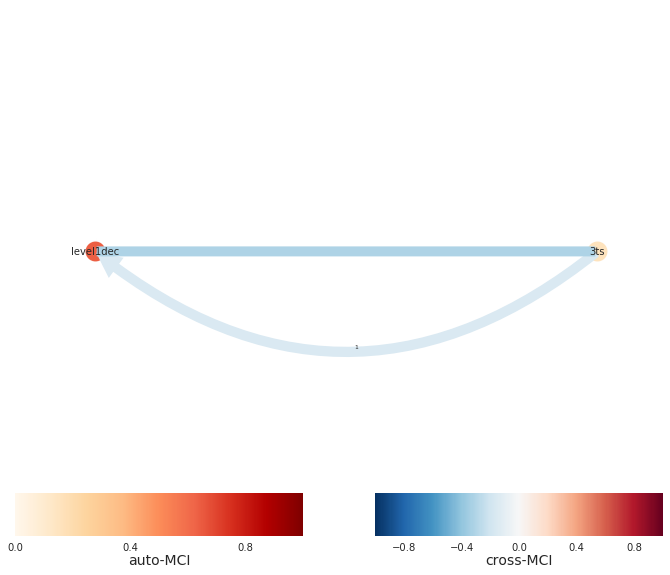

In [66]:
rg.PCMCI_plot_graph()

Plotting Corr maps sst_labels_init, split 0, lag 0

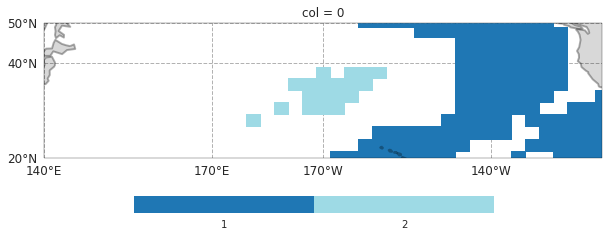

In [67]:
rg.quick_view_labels()